# [GN-3]Word_Embedding

이번 프로젝트는 영화 시놉시스 코퍼스를 가지고, 영화의 구분(예술영화 인가 또는 일반 영화인가)과 영화 장르(드라마, 공포, 가족 등 ) 간에    
숨어있는 편향성의 정도(WEAT score)를 수치적으로 측정해보는 작업이다.    

### 메인 주제 : `WEAT Score 통해 코퍼스 내에 편향성을 분석하자` 
#### 진행 단계   
- STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기
- STEP 2. 추출된 결과로 embedding model 만들기
- STEP 3. target, attribute 단어 셋 만들기
- STEP 4. WEAT score 계산과 시각화

### 탐색 주제:   `중복 단어가 Weat 분석에 어떤 영향을 미칠까?`
STEP 3에서 TF-IDF의 단어셋을 만들었을 때 장르별 키워드에서 중복 단어의 문제가 발생한다.    
그래서 이것을   
    - 중복이 제거 되지 않은 경우(기본)   
    - 일부 중복이 포함된 경우    
    - 전혀 중복되지 않은 경우   

3가지 경우로 나누어서 이 중복의 정도가 Weat Score를 통한 편향성 판단에 어떤 영향이 있는지 탐색하고자 한다.

## STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

### 1.1 Data load

In [11]:
import os

with open('./weat/synopsis.txt', 'r', encoding='utf8') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [12]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open('./weat/synopsis.txt', 'r', encoding='utf8') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

print("슝~")

슝~


In [132]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('./weat/'+file_name, 'r', encoding='utf8') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

print("슝~")

슝~


In [133]:
def read_token_list(file_name):
    okt = Okt()
    result = []
    with open('./weat_token/'+file_name, 'r', encoding='utf8') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            res = []
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    res.append((word[0])) 
            result.append(res)
    return result

### 1.2 Tokenize 및 Token 데이타 저장

#### 1.2.1 예술영화(Art), 일반영화(Gen) 데이타 Token 추출

In [139]:
import pickle
art_txt = 'synopsis_art.txt'
art = read_token(art_txt)
with open('./weat_token/token_art.txt', 'w',encoding='utf8') as file:    
     file.writelines(art)


synopsis_art.txt 파일을 읽고 있습니다.


In [131]:
gen_txt = 'synopsis_gen.txt'
gen = read_token(gen_txt)
with open('./weat_token/token_gen.txt', 'w',encoding='utf8') as file:    
    file.writelines(gen)

synopsis_gen.txt 파일을 읽고 있습니다.


#### 1.2.2 다른 장르 데이타 Token 추출

In [169]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', 
              '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', 
              '미스터리', '범죄', '사극', '서부극(웨스턴)',
              '성인물(에로)', '스릴러', '애니메이션', '액션', 
              '어드벤처', '전쟁', '코미디', '판타지']

print("슝~")

슝~


In [173]:
# 파일저장
genre = []
for file_name in genre_txt:
    m = read_token(file_name)
    genre.append(m) 
    with open('./weat_token/token_{}.txt'.format(file_name.split('.txt')[0]), 'w',encoding='utf8') as file:   
        file.writelines(m)
    

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


## STEP2.추출된 결과로 embedding model 만들기

In [147]:
art_txt = 'token_art.txt'
art = read_token_list(art_txt)

token_art.txt 파일을 읽고 있습니다.


In [134]:
gen_txt = 'token_gen.txt'
gen = read_token_list(gen_txt)

token_gen.txt 파일을 읽고 있습니다.


In [184]:
# 단어장
from gensim.models import Word2Vec
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['사랑'])

[('첫사랑', 0.7030643820762634),
 ('행복', 0.7028871178627014),
 ('애정', 0.6934080123901367),
 ('존경심', 0.6914240717887878),
 ('이별', 0.6900613307952881),
 ('만남', 0.6865081191062927),
 ('진심', 0.6809321045875549),
 ('연애', 0.6805367469787598),
 ('콜슨', 0.6784914135932922),
 ('운명', 0.6753424406051636)]

In [403]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['전쟁'])

[('학살', 0.7594226598739624),
 ('부족', 0.7412494421005249),
 ('전투', 0.739590585231781),
 ('내전', 0.7334848046302795),
 ('소용돌이', 0.7322874069213867),
 ('산화', 0.722258448600769),
 ('격변', 0.7207536697387695),
 ('생존', 0.7190372347831726),
 ('조국', 0.7141138911247253),
 ('선포', 0.7096174955368042)]

In [404]:
from gensim.models import Word2Vec
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['판타지'])

[('스토리', 0.9458966255187988),
 ('선사', 0.9412108063697815),
 ('시적', 0.9346486330032349),
 ('코믹', 0.9329067468643188),
 ('해석', 0.9208292961120605),
 ('내러티브', 0.920233964920044),
 ('감성', 0.9190583825111389),
 ('주제', 0.9182579517364502),
 ('감동', 0.9151443839073181),
 ('몽환', 0.9145368933677673)]

# STEP 3. target, attribute 단어 셋 만들기

### 3.1 Target 단어 셋 만들기

In [160]:
vectorizer = TfidfVectorizer()
art_str = ' '.join(art[0])
gen_str = ' '.join(gen[0])
X = vectorizer.fit_transform([art_str, gen_str])

print(X.shape)

(2, 40026)


In [162]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names_out()[23357])

23357
영화


In [163]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 결혼, 사고, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [164]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [165]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [166]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


### 3.2 저장된 장르 토큰 데이타 읽기

In [175]:
# 파일로 저장한 장르 토큰 파일 읽기
def read_token_file(file_name):
    
    file_name ='token_' + file_name 
    with open('./weat_token/'+file_name, 'r', encoding='utf8') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        tokens = fread.read() 
    return tokens

In [176]:
genre = []
for file_name in genre_txt:
    m = read_token_file(file_name)
    genre.append(m)

token_synopsis_SF.txt 파일을 읽고 있습니다.
token_synopsis_family.txt 파일을 읽고 있습니다.
token_synopsis_show.txt 파일을 읽고 있습니다.
token_synopsis_horror.txt 파일을 읽고 있습니다.
token_synopsis_etc.txt 파일을 읽고 있습니다.
token_synopsis_documentary.txt 파일을 읽고 있습니다.
token_synopsis_drama.txt 파일을 읽고 있습니다.
token_synopsis_romance.txt 파일을 읽고 있습니다.
token_synopsis_musical.txt 파일을 읽고 있습니다.
token_synopsis_mystery.txt 파일을 읽고 있습니다.
token_synopsis_crime.txt 파일을 읽고 있습니다.
token_synopsis_historical.txt 파일을 읽고 있습니다.
token_synopsis_western.txt 파일을 읽고 있습니다.
token_synopsis_adult.txt 파일을 읽고 있습니다.
token_synopsis_thriller.txt 파일을 읽고 있습니다.
token_synopsis_animation.txt 파일을 읽고 있습니다.
token_synopsis_action.txt 파일을 읽고 있습니다.
token_synopsis_adventure.txt 파일을 읽고 있습니다.
token_synopsis_war.txt 파일을 읽고 있습니다.
token_synopsis_comedy.txt 파일을 읽고 있습니다.
token_synopsis_fantasy.txt 파일을 읽고 있습니다.


In [177]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


### 3.3 중복이 허용된 장르별 핵심 단어 추출

In [178]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
keywords_str = ''
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            keywords_str += ','+ vectorizer.get_feature_names_out()[w[i][j][0]]
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
 
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아버지, 시작, 그녀, 아들, 마을, 국제, 할머니, 사랑, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 백작, 프레, 베르디, 위해, 왕자, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 페스티벌, 여자, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 카바, 영화제, 바흐, 시작, 샤오캉, 위해, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 사랑, 자신, 황제, 그녀, 최고, 운명, 사람, 전쟁, 트로이, 노준, 권력, 사건, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 헨리, 마을, 자신, 아이, 시작, 무법자, 현상금, 분노, 스탠리, 가족, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 시작, 위해, 사람, 

📝중복된 단어가 많이 보인다. 위해, 그녀, 시작, 사람, 사랑 등등... 일단 중복된 단어를 모두 포함해서 WEAT Score까지 진행해 보자.    
이것을 베이스 라인으로 다음에는 중복을 단계별로 제거해 보자. 


# STEP4. embedding model과 단어 셋으로 WEAT score 구해보기

In [179]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
print("슝~")

슝~


In [180]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [181]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b
def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

In [182]:
def show_weat_score(matrix, attributes):
    X = np.array([model.wv[word] for word in target_art])
    Y = np.array([model.wv[word] for word in target_gen])

    for i in range(len(genre_name)-1):
        for j in range(i+1, len(genre_name)):
            A = np.array([model.wv[word] for word in attributes[i]])
            B = np.array([model.wv[word] for word in attributes[j]])
            matrix[i][j] = round(weat_score(X, Y, A, B),3)

    for i in range(len(genre_name)-1):
        for j in range(i+1, len(genre_name)):
            if matrix[i][j] >0.8 or matrix[i][j] <-0.8:
                print(genre_name[i], genre_name[j],matrix[i][j])

In [186]:
show_weat_score(matrix, attributes)

SF 어드벤처 -0.899
가족 기타 0.804
가족 다큐멘터리 0.905
가족 애니메이션 0.943
공연 기타 0.875
공연 다큐멘터리 0.925
공연 뮤지컬 0.894
공연 애니메이션 0.924
기타 드라마 -0.882
기타 멜로로맨스 -0.884
기타 성인물(에로) -0.8
다큐멘터리 드라마 -0.911
다큐멘터리 멜로로맨스 -0.887
다큐멘터리 뮤지컬 -0.883
다큐멘터리 사극 -0.816
다큐멘터리 성인물(에로) -0.819
다큐멘터리 어드벤처 -0.924
다큐멘터리 코미디 -0.825
다큐멘터리 판타지 -0.893
드라마 멜로로맨스 -0.818
드라마 애니메이션 0.879
멜로로맨스 뮤지컬 0.825
멜로로맨스 범죄 0.824
멜로로맨스 성인물(에로) 0.822
멜로로맨스 애니메이션 0.859
멜로로맨스 코미디 0.886
멜로로맨스 판타지 0.82
미스터리 범죄 1.0
범죄 스릴러 -0.93
애니메이션 어드벤처 -0.878


In [247]:
import pandas as pd
df_all = pd.DataFrame(columns=['A-B', 'weat'])
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        df_all.loc[len(df_all)]= [genre_name[i]+'-'+genre_name[j],matrix[i][j]]

In [406]:
df_all.sort_values(by='A-B', ascending=True).head()

,A-B,weat
0,SF-가족,-0.658
1,SF-공연,-0.423
2,SF-공포(호러),-0.676
3,SF-기타,0.263
4,SF-다큐멘터리,0.587


In [ ]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt

def show_weat_matrix(title, matrix):
    plt.figure(figsize=(15,8))
    np.random.seed(0)

    # 한글 지원 폰트
    sns.set(font='NanumGothic')
    plt.rcParams['axes.unicode_minus'] = False
    ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,
                     cmap='RdYlGn_r',annot_kws={"size": 9}, linewidths=.5)
    plt.grid(True)
    plt.title(title)
    plt.show()

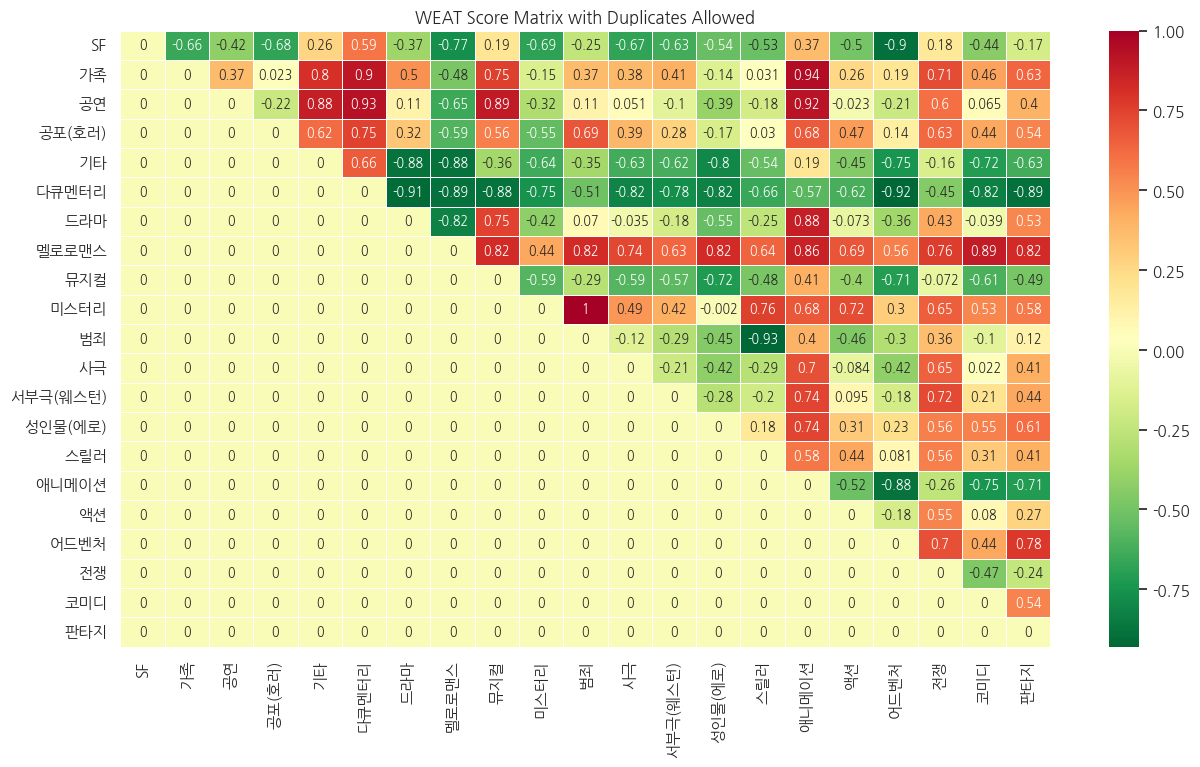

In [327]:
show_weat_matrix('WEAT Score Matrix with Duplicates Allowed',matrix )


# STEP5 장르별 핵심단어 중복 제거

### 5.1 일부 중복단어 제거

In [218]:
from collections import Counter
exept_words = []
words = keywords_str.split(',')
word_counts = Counter(words)
for word, count in word_counts.items():
    if count>=4:
        print(f"'{word}': {count}")
        exept_words.append(word)


'위해': 21
'자신': 21
'시작': 20
'사람': 16
'그녀': 16
'세계': 4
'모든': 4
'가족': 6
'영화제': 8
'친구': 10
'마을': 7
'국제': 5
'사랑': 10
'사건': 7
'남자': 10
'영화': 8
'이야기': 5
'여자': 5


In [219]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes_ex = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            if (vectorizer.get_feature_names_out()[w[i][j][0]] not in exept_words):
                keywords_str += ','+ vectorizer.get_feature_names_out()[w[i][j][0]]
                attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
                print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes_ex.append(attr)
 
    print()

SF: 지구, 인류, 인간, 미래, 우주, 로봇, 박사, 우주선, 외계, 존재, 세상, 발견, 행성, 정체, 비밀, 
가족: 엄마, 아빠, 아주르, 아버지, 아들, 낙타, 할머니, 씨제이, 동구, 아이, 학교, 세상, 소년, 슈이트, 가장, 
공연: 오페라, 토스카, 실황, 올레, 카바, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 카르피, 비바, 왕자, 콘서트, 
공포(호러): 공포, 발견, 죽음, 악령, 좀비, 사실, 소녀, 하나, 살인, 비밀, 아이, 정체, 저주, 살해, 의문, 
기타: 서울, 단편, 뉴미디어, 페스티벌, 대한, 독립, 작품, 엄마, 통해, 아시아나, 다른, 우리, 연출, 소녀, 모습, 
다큐멘터리: 다큐, 다큐멘터리, 대한, 감독, 서울, 우리, 통해, 여성, 한국, 작품, 환경, 사회, 모습, 아이, 노동자, 
드라마: 엄마, 아버지, 단편, 서울, 대한, 아들, 마음, 아이, 남편, 서로, 시간, 소녀, 세상, 감독, 다른, 
멜로로맨스: 남편, 섹스, 마음, 결혼, 서로, 아내, 관계, 부부, 엄마, 아버지, 사실, 점점, 다시, 회사, 시간, 
뮤지컬: 뮤지컬, 에스메랄다, 음악, 충무로, 모차르트, 토스카, 니웨, 카바, 바흐, 페뷔스, 프롤, 모도, 카르피, 제루샤, 샤오캉, 
미스터리: 발견, 사고, 진실, 죽음, 기억, 살인, 아내, 아이, 민혁, 사실, 의문, 미스터리, 형사, 하나, 비밀, 
범죄: 경찰, 범죄, 조직, 살인, 마약, 형사, 살해, 수사, 발견, 한길수, 범인, 계획, 은행, 작전, 아버지, 
사극: 조선, 신기전, 아가멤논, 황제, 루안, 최고, 운명, 하선, 전쟁, 윤서, 트로이, 세자, 허균, 노준, 채선, 
서부극(웨스턴): 서부, 보안관, 벌린, 카우보이, 그레이프바인, 헨리, 개릿, 아이, 무법자, 프린트, 마적, 태구, 현상금, 분노, 버질, 
성인물(에로): 남편, 마사지, 섹스, 관계, 정사, 유부녀, 마음, 에피소드, 그린, 아내, 다시, 자위, 회사, 불륜, 사실, 
스릴러: 

📝 4번이상 중복된 단어를 제외하고 다시 핵심 단어를 뽑았지만, 다시 중복단어들이 보인다.  아이, 아버지 등등   
그리고 공연, 서부극(웨스턴), 뮤지컬 등에는 작품 설명으로 인해 고유명사인 인물이름들이 많이 보인다.

In [220]:
matrix_ex = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
show_weat_score(matrix_ex ,attributes_ex)

SF 어드벤처 -0.836
가족 기타 0.859
가족 다큐멘터리 0.892
가족 애니메이션 0.878
기타 드라마 -0.918
기타 멜로로맨스 -0.812
기타 어드벤처 -0.849
기타 코미디 -0.844
다큐멘터리 드라마 -0.937
다큐멘터리 멜로로맨스 -0.844
다큐멘터리 어드벤처 -0.914
다큐멘터리 코미디 -0.905
다큐멘터리 판타지 -0.828
드라마 애니메이션 0.853
범죄 스릴러 -0.847
범죄 액션 -0.883
애니메이션 어드벤처 -0.834


In [248]:
import pandas as pd
df_ex = pd.DataFrame(columns=['A-B_ex', 'weat_ex'])
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        df_ex.loc[len(df_ex)]= [genre_name[i]+'-'+genre_name[j],matrix_ex[i][j]]

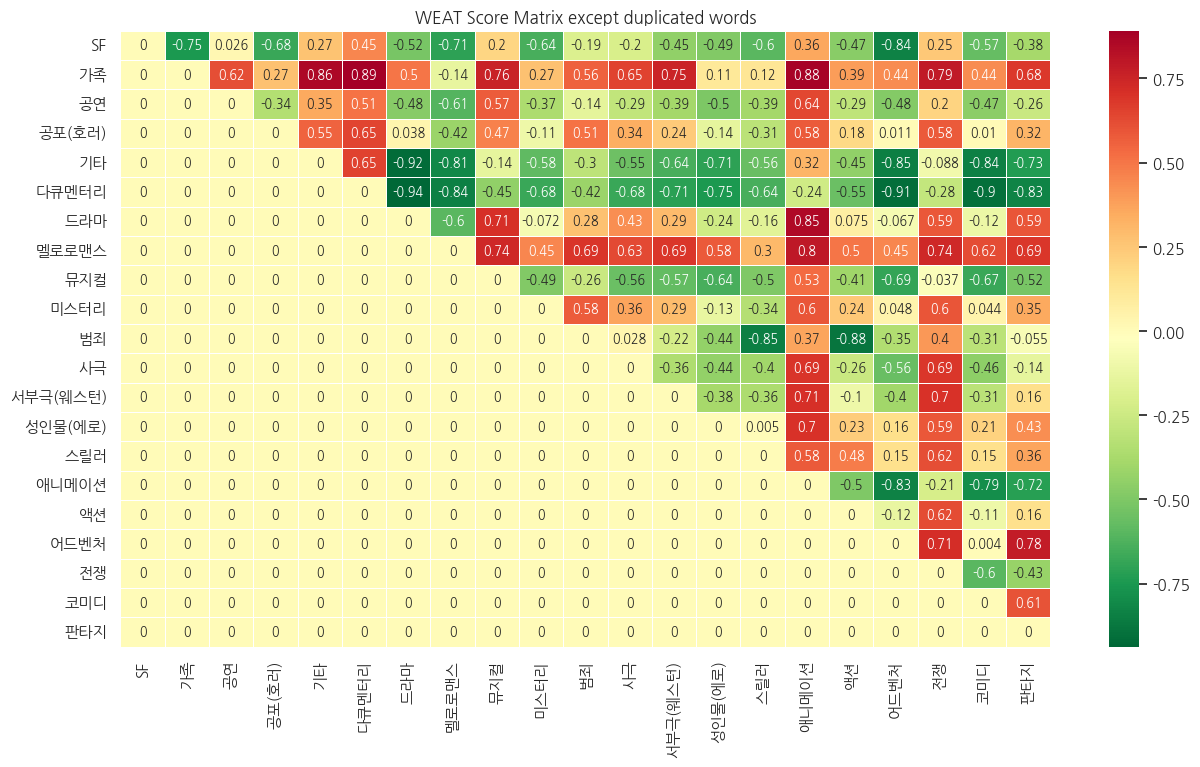

In [227]:
show_weat_matrix('WEAT Score Matrix except duplicated words', matrix_ex)

### 5.2중복이 하나도 없이 핵심단어 추출

In [350]:
from collections import Counter
exept_words = []
words = keywords_str.split(',')
word_counts = Counter(words)
for word, count in word_counts.items():
    if count>=2:
        exept_words.append(word)

In [353]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes_only = []

only_words = set(exept_words)  # 중복값없이 데이타를 받아두기 위해서 Set를 이용함. 
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names_out()[w[i][j][0]] in model.wv:
            if (vectorizer.get_feature_names_out()[w[i][j][0]] not in only_words):
                only_words.add(vectorizer.get_feature_names_out()[w[i][j][0]])
                attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
                print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes_only.append(attr)
 
    print()

SF: 외계, 행성, 공격, 실험, 능력, 시스템, 위협, 생명체, 정부, 스타크, 리플리, 과학자, 음모, 파괴, 켈빈, 
가족: 아주르, 낙타, 씨제이, 동구, 학교, 슈이트, 가장, 어머니, 마갈, 미아, 펠리칸, 모두, 혼자, 벤트, 케이시, 
공연: 리골레토, 비바, 콘서트, 백작부인, 반니, 아리아, 미노, 차이코프스키, 라다, 무대, 도시, 공작, 리코, 파우스트, 메스, 
공포(호러): 저주, 명의, 이후, 일행, 시체, 계속, 악몽, 병원, 파티, 유령, 실종, 발생, 게임, 귀신, 악마, 
기타: 뉴미디어, 독립, 아시아나, 연출, 이미지, 부산, 상영작, 지하철, 청소년, 생각, 현실, 유럽, 부천, 사이, 노인, 
다큐멘터리: 여성, 한국, 환경, 사회, 노동자, 기록, 역사, 미국, 카메라, 동안, 대해, 과정, 지역, 투쟁, 인디다큐페스티발, 
드라마: 때문, 부문, 생활, 인생, 간다, 순간, 일상, 의도, 상황, 감정, 경쟁, 하루, 마지막, 과거, 가지, 
멜로로맨스: 부부, 유혹, 연애, 애인, 새엄마, 불륜, 남자친구, 출장, 선배, 여자친구, 커플, 만난, 고백, 동거, 몰래, 
뮤지컬: 에스메랄다, 니웨, 페뷔스, 프롤, 모도, 제루샤, 데이비, 팬텀, 크리스틴, 애니, 노트르담, 라훌, 캬바레, 안젤로, 노래, 
미스터리: 민혁, 미스터리, 현우, 방독면, 충격, 소설, 용의자, 여인, 추적, 의심, 수사, 사진, 조사, 랭던, 몰카, 
범죄: 한길수, 계획, 은행, 동료, 보스, 마피아, 복수, 제안, 이자, 프랭크, 감옥, 납치, 현장, 파푸아, 금고, 
사극: 신기전, 아가멤논, 루안, 하선, 윤서, 세자, 허균, 채선, 신재효, 히파티아, 권력, 아킬레스, 양반, 정조, 광해군, 
서부극(웨스턴): 그레이프바인, 개릿, 프린트, 마적, 태구, 버질, 랜던, 스탠리, 제임스, 교수형, 장고, 만도, 듀발, 마리아, 사냥, 
성인물(에로): 에피소드, 그린, 자위, 욕구, 유이, 욕구불만, 손님, 유우, 성적, 성관계

📝중복 단어를 제거하고 나니 눈에 띄게 고유명사인 이름이 들어가 있다. (차이코프스키, 파우스트, 크리스틴, 신재효, 허균, 아가멤논, 남보라 등등)

In [354]:
matrix_only = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]
show_weat_score(matrix_only ,attributes_only)

SF 가족 -0.951
SF 공포(호러) -1.016
SF 멜로로맨스 -0.899
SF 서부극(웨스턴) -0.87
SF 스릴러 -1.0
SF 애니메이션 -0.857
SF 어드벤처 -0.984
가족 기타 0.908
가족 다큐멘터리 0.891
가족 사극 1.01
공연 기타 0.846
공연 멜로로맨스 -0.836
공연 어드벤처 -0.805
공연 코미디 -0.81
공포(호러) 사극 0.808
공포(호러) 액션 0.823
기타 드라마 -0.86
기타 멜로로맨스 -0.933
기타 뮤지컬 -0.854
기타 서부극(웨스턴) -0.847
기타 성인물(에로) -0.823
기타 애니메이션 -0.807
기타 어드벤처 -0.921
기타 코미디 -0.901
기타 판타지 -0.842
다큐멘터리 드라마 -0.883
다큐멘터리 멜로로맨스 -0.872
다큐멘터리 스릴러 -0.814
다큐멘터리 어드벤처 -0.849
드라마 멜로로맨스 -0.806
멜로로맨스 뮤지컬 0.855
멜로로맨스 미스터리 0.84
멜로로맨스 사극 0.939
멜로로맨스 성인물(에로) 1.009
멜로로맨스 액션 0.806
멜로로맨스 전쟁 0.851
멜로로맨스 판타지 0.819
사극 서부극(웨스턴) -1.053
사극 스릴러 -0.828
사극 애니메이션 -0.85
사극 어드벤처 -1.147
사극 코미디 -0.821
사극 판타지 -0.898
서부극(웨스턴) 전쟁 0.836


In [355]:
import pandas as pd
df_only = pd.DataFrame(columns=['A-B_only', 'weat_only'])
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        df_only.loc[len(df_only)]= [genre_name[i]+'-'+genre_name[j],matrix_only[i][j]]

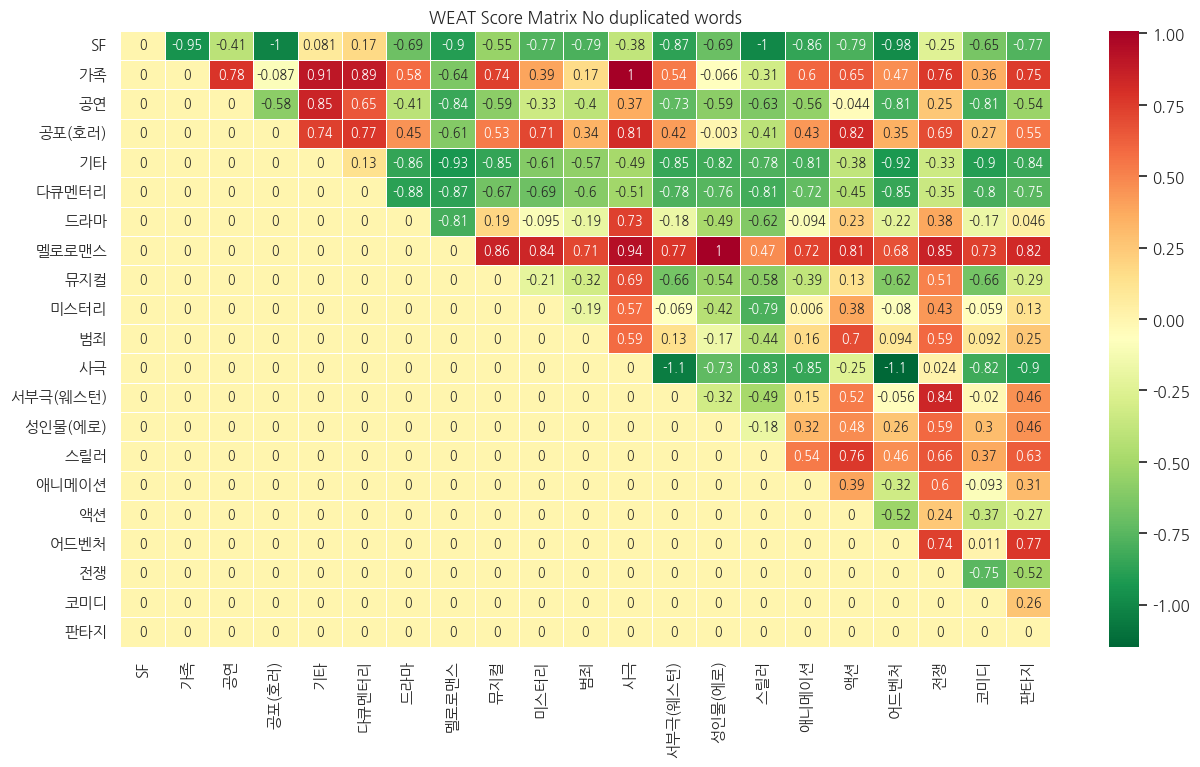

In [356]:
show_weat_matrix('WEAT Score Matrix No duplicated words', matrix_only)

# STEP6. 3가지 case의 WEAT Score 데이타 분석

###  검증하고자 하는 내용은 `장르별 중복 키워드가 WEAT Score에 영향을 주는가 ❓ `


## 6.1 3가지 case에 대해서 Data 결합

In [357]:
df_temp = df_all.merge(df_ex, left_index=True, right_index=True)
df_combined = df_temp.merge(df_only, left_index=True, right_index=True)

In [358]:
df_combined.head()

,A-B,weat,A-B_ex,weat_ex,A-B_only,weat_only
0,SF-가족,-0.658,SF-가족,-0.751,SF-가족,-0.951
1,SF-공연,-0.423,SF-공연,0.026,SF-공연,-0.409
2,SF-공포(호러),-0.676,SF-공포(호러),-0.677,SF-공포(호러),-1.016
3,SF-기타,0.263,SF-기타,0.268,SF-기타,0.081
4,SF-다큐멘터리,0.587,SF-다큐멘터리,0.453,SF-다큐멘터리,0.173


📝 중복을 제거하지 않은 데이타(weat), 중복을 일부 제거한 데이타(weat_ex), 중복을 완전히 제거한 데이타 (weat_only) 데이타를 합하여 하나의
dataframe으로 만든다.

## 6.2 최초 Weat Score에서의 변화 
 3-3에서 중복이 허용된 장르별 핵심단어들 중에서 WEAT Score가 -0.8이하 이거나 0.8이상인 편향성이 높다고 검증된 데이타들이 이후에 어떤 추이가 되었는지 분석해보자. 

In [388]:
df_change = df_combined[(df_combined['weat']>0.8) | (df_combined['weat']<-0.8)][['A-B','weat','weat_ex','weat_only']]

In [389]:
df_change

,A-B,weat,weat_ex,weat_only
16,SF-어드벤처,-0.899,-0.836,-0.984
22,가족-기타,0.804,0.859,0.908
23,가족-다큐멘터리,0.905,0.892,0.891
33,가족-애니메이션,0.943,0.878,0.602
40,공연-기타,0.875,0.353,0.846
41,공연-다큐멘터리,0.925,0.510,0.649
44,공연-뮤지컬,0.894,0.574,-0.588
51,공연-애니메이션,0.924,0.638,-0.560
75,기타-드라마,-0.882,-0.918,-0.860
76,기타-멜로로맨스,-0.884,-0.812,-0.933


📝다큐멘터리 코미디(-0.825, -0.905,-0.871 )와 같이 큰 변화없이 높은 편향성을 유지하는 것도 있지만,    
미스터리-범죄(1.00, 0.596, -0.194)과 같이 급격한 변화를 보이는 데이타도 있다. 

In [390]:
df_melted = df_change.melt(id_vars='A-B', value_vars=['weat', 'weat_ex', 'weat_only'], var_name='Type', value_name='Value')

In [392]:
df_melted.head()

,A-B,Type,Value
0,SF-어드벤처,weat,-0.899
1,가족-기타,weat,0.804
2,가족-다큐멘터리,weat,0.905
3,가족-애니메이션,weat,0.943
4,공연-기타,weat,0.875


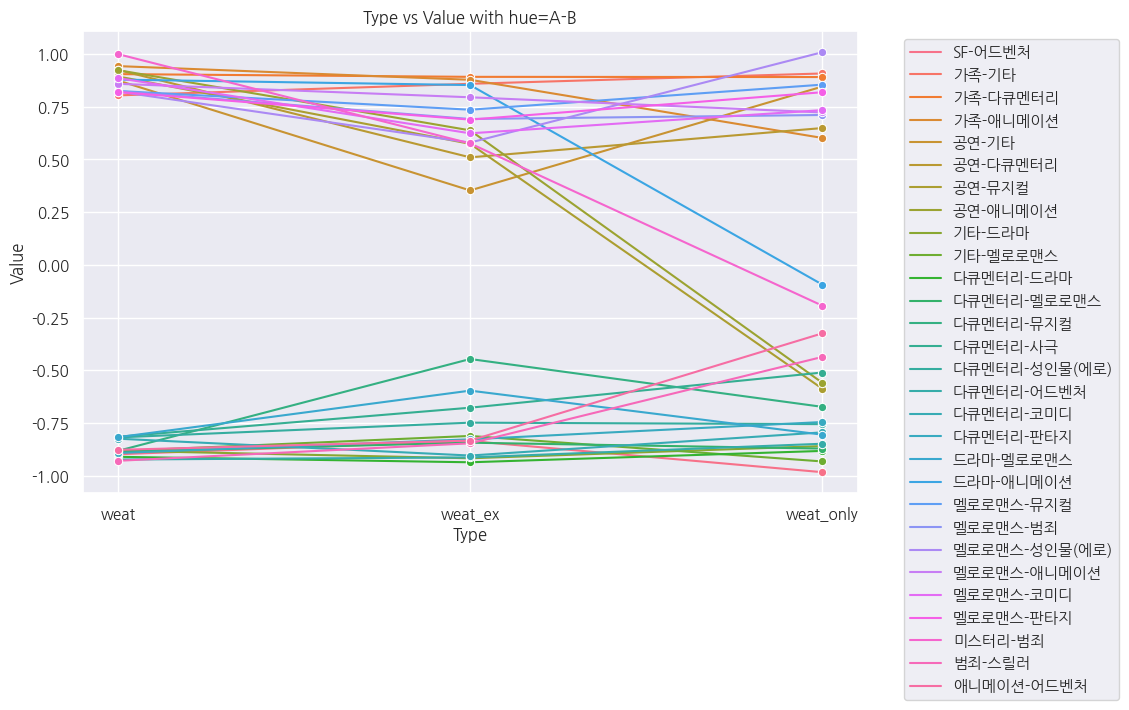

In [393]:

plt.figure(figsize=(10,6))  # 그래프 크기 설정
sns.lineplot(x='Type', y='Value', hue='A-B', data=df_melted, marker='o')

plt.title('Type vs Value with hue=A-B')  # 그래프 제목 설정
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # 범례를 그래프 밖으로 위치시킵니다.


plt.show()  # 그래프 출력

📝대부분 크게 변화는 없지만 급격한 변화가 있는 장르가 있다. Weat에서 Weat_only로 급격한 차이를 보이는 데이타를 찾아보자. 

In [394]:
# 오차를 저장 전체 데이타를 대상으로 봄
df_combined['diff'] = (df_combined['weat'])**2-(df_combined['weat_only'])**2

In [395]:
# 오차가 0.5보다 큰 데이타 저장
df_change = df_combined[df_combined['diff']>0.5].sort_values(by='diff', ascending=True)

In [398]:
df_change

,A-B,weat,A-B_ex,weat_ex,A-B_only,weat_only,diff
176,서부극(웨스턴)-애니메이션,0.737,서부극(웨스턴)-애니메이션,0.711,서부극(웨스턴)-애니메이션,0.148,0.521265
33,가족-애니메이션,0.943,가족-애니메이션,0.878,가족-애니메이션,0.602,0.526845
106,드라마-뮤지컬,0.751,드라마-뮤지컬,0.712,드라마-뮤지컬,0.187,0.529032
51,공연-애니메이션,0.924,공연-애니메이션,0.638,공연-애니메이션,-0.560,0.540176
198,애니메이션-코미디,-0.748,애니메이션-코미디,-0.787,애니메이션-코미디,-0.093,0.550855
196,애니메이션-어드벤처,-0.878,애니메이션-어드벤처,-0.834,애니메이션-어드벤처,-0.325,0.665259
158,범죄-스릴러,-0.930,범죄-스릴러,-0.847,범죄-스릴러,-0.437,0.673931
113,드라마-애니메이션,0.879,드라마-애니메이션,0.853,드라마-애니메이션,-0.094,0.763805
144,미스터리-범죄,1.000,미스터리-범죄,0.576,미스터리-범죄,-0.194,0.962364


In [396]:
df_melted = df_change.melt(id_vars='A-B', value_vars=['weat', 'weat_ex', 'weat_only'], var_name='Type', value_name='Value')

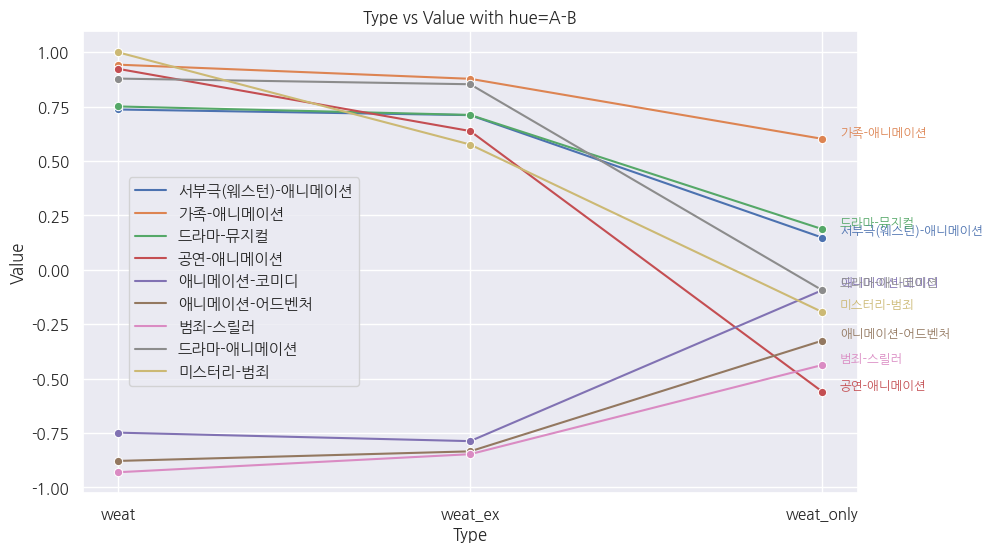

In [397]:
import seaborn as sns

plt.figure(figsize=(10,6))  # 그래프 크기 설정
lineplot = sns.lineplot(x='Type', y='Value', hue='A-B', data=df_melted, marker='o')

plt.title('Type vs Value with hue=A-B')  # 그래프 제목 설정
plt.legend(bbox_to_anchor=(0.05, 0.7), loc='upper left')  # 범례를 그래프 밖으로 위치시킵니다.

# 각 선에 대해 마지막 데이터 포인트에 텍스트를 추가합니다.
for line, name in zip(lineplot.lines, df_melted['A-B'].unique()):
    y = line.get_ydata()[-1]
    plt.text(2.05, y, name, color=line.get_color(), fontsize=9 , verticalalignment='bottom')

plt.show()  # 그래프 출력

📝 큰 변화율을 보인 데이타들을 중심으로 살펴보았다. 

In [368]:
df_change

,A-B,weat,A-B_ex,weat_ex,A-B_only,weat_only,diff
176,서부극(웨스턴)-애니메이션,0.737,서부극(웨스턴)-애니메이션,0.711,서부극(웨스턴)-애니메이션,0.148,0.521265
33,가족-애니메이션,0.943,가족-애니메이션,0.878,가족-애니메이션,0.602,0.526845
106,드라마-뮤지컬,0.751,드라마-뮤지컬,0.712,드라마-뮤지컬,0.187,0.529032
51,공연-애니메이션,0.924,공연-애니메이션,0.638,공연-애니메이션,-0.560,0.540176
198,애니메이션-코미디,-0.748,애니메이션-코미디,-0.787,애니메이션-코미디,-0.093,0.550855
196,애니메이션-어드벤처,-0.878,애니메이션-어드벤처,-0.834,애니메이션-어드벤처,-0.325,0.665259
158,범죄-스릴러,-0.930,범죄-스릴러,-0.847,범죄-스릴러,-0.437,0.673931
113,드라마-애니메이션,0.879,드라마-애니메이션,0.853,드라마-애니메이션,-0.094,0.763805
144,미스터리-범죄,1.000,미스터리-범죄,0.576,미스터리-범죄,-0.194,0.962364


극적인 변화를 보였던 미스터리-범죄의 실제 키워들을 보면 아래와 같다. 
- 중복을 허용했던 데이타의 실제 키워드를 모면 두 장르가 사실 크게 다르다고 보이지 않는다. 
- 그런데도 WEAT score가 1로 높게 나온것은 이해하기 어렵다. 
- 그런 점에서 중복을 없애고 나온 -0.194라는 score가 더 설득력이 있어보인다. 

드라마-애니메이션 키워드도 비교해보면, 
- 중복을 허용했던 데이타는 중복된 키워드(시작, 위해, 자신, 친구, 이야기, 영화제)가 다수 있는데도 WEAT score 0.879가 나온 것은 너무 높게 나온 듯 하다. 
- 두 단어들 사이에서도 크게 차이가 없어보인다. 
- 중복을 허용하지 않은 데이타에서는 특징이 더 잘 표현된 단어들이(애니메이션: 마법, 왕국, 괴물)있고, 둘다 예술영화와 일반영화의 편향으로 본다면 크게 차이는 없어보여, 
- -0.094 편향이 없다고 보는 것이 초기에 중복허용시에 0.879보다 더 신뢰가 가는 결과이다.<br>       
<img src='https://user-images.githubusercontent.com/95423215/243104804-48fbd027-03fe-4e5d-9523-aceda261e560.png'>


키워드에 중복을 허용했을 때와 중복을 허용하지 않았을 때의 Heat Map을 비교해 보았다.    
- 전체적으로 해당 장르에 대한 예술영화와 일반영화 사이에 편향의 흐름은 비슷하게 보인다.    
- 기타, 다큐멘터리는 다른 장르들에 비해 일반영화로의 편향이 좀 더 있어 보인다. (거의 초록색)
- 멜로 로맨스는 다른 장르들에 비해 예술영화로의 편향이 두드러져 보인다. (붉은색)
- 중복단어가 없는 대신 고유명사인 이름들이 포함된 것이 보인다. (민혁, 현우, 한길수, 프랭크, 파푸아)

<img src='https://user-images.githubusercontent.com/95423215/243104801-284a769b-1600-4a98-8bab-1639c9f1fe8c.png'>
<img src='https://user-images.githubusercontent.com/95423215/243104805-900de4f5-ac4a-4dd4-8493-fbd6f8b7a16e.png'>



## 🧐 결론적으로 중복 단어가 적을 수록 WEAT Score가 좀 더 객과적인 지표를 보여준다고 결론 내릴 수 있다. 
- 중복 단어를 제거하면 해당 장르를 표현하는 좀 더 정밀한 단어들을 포함시킬 수 있다. 
- 그러나 공유명사가 너무 많이 포함되는 문제점도 있다. 

# Step7 Weat Score 해석

중복을 제거한 데이타를 기반으로 WEAT Score 해석하자.

In [405]:
show_weat_score(matrix_only ,attributes_only)

SF 가족 -0.952
SF 공포(호러) -1.03
SF 멜로로맨스 -0.915
SF 범죄 -0.811
SF 서부극(웨스턴) -0.89
SF 스릴러 -1.008
SF 애니메이션 -0.875
SF 액션 -0.816
SF 어드벤처 -1.066
SF 판타지 -0.812
가족 기타 0.887
가족 다큐멘터리 0.888
가족 사극 1.007
공연 기타 0.887
공연 멜로로맨스 -0.82
공포(호러) 사극 0.82
공포(호러) 액션 0.854
기타 드라마 -0.844
기타 멜로로맨스 -0.926
기타 뮤지컬 -0.854
기타 서부극(웨스턴) -0.83
기타 성인물(에로) -0.819
기타 애니메이션 -0.8
기타 어드벤처 -0.922
기타 코미디 -0.889
기타 판타지 -0.864
다큐멘터리 드라마 -0.894
다큐멘터리 멜로로맨스 -0.88
다큐멘터리 스릴러 -0.817
다큐멘터리 어드벤처 -0.879
다큐멘터리 코미디 -0.806
드라마 멜로로맨스 -0.815
멜로로맨스 뮤지컬 0.848
멜로로맨스 미스터리 0.849
멜로로맨스 사극 0.953
멜로로맨스 성인물(에로) 0.995
멜로로맨스 액션 0.823
멜로로맨스 전쟁 0.856
멜로로맨스 판타지 0.809
사극 서부극(웨스턴) -1.091
사극 스릴러 -0.838
사극 애니메이션 -0.843
사극 어드벤처 -1.182
사극 코미디 -0.815
사극 판타지 -0.972
서부극(웨스턴) 전쟁 0.824


## 📝Target X: 예술 영화, Target Y: 일반 영화에 대해서   
### `Attribute A: SF 와 Attribute B: 가족` 의 경우 `WEAT score: -0.952` 의미
- SF 장르는 일반영화에 더 상관관계가 있다. 가족 장르는 예술영화에 더 편향이 있다고 할 수 있다. 

### `Attribute A: 멜로로멘스 와 Attribute B: 미스터리`의 경우 `WEAT score: 0.849` 의미
- 멜로로맨스 장르는 예술영화에 더 편향이 있고, 미스터리 장르의 경우 일반 영화에 더 편향이 있다고 할 수 있다. 

# 회고

- 시놉시스 파일을 읽어들이는 부분에서 시간이 많이 걸리므로 일단 읽어들이고, 토큰화 시킨후에 파일로 저장에서 나중에도 토큰만 불러들일 수 있도록 작업했다. 
- Node에서 설명했던 소스 코드를 그대로 쓰면 무리없이 할 수 있는 프로젝트였다. 그래서 추가로 탐구 주제를 잡고 궁금했던 부분을 더 깊이있게 탐구할 수 있었다. 
- 중복 단어를 제거 했을 때 장르별 의미있는 단어들이 도출되서 만족스러웠지만, 고유명사들이 대거 들어와서 이것을 구별해서 빼주는 작없도 필요하지 않을까 생각했다. 
- 이번 프로젝트를 통해서, 워드 임베딩, 단어장, 벡터화에 대한 개념을 확실히 할 수 있었다. 